In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
# Function to preprocess image
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    if img is None:
        raise FileNotFoundError(f"PNG file {image_path} not found")

    # Normalize and resize
    img = img.astype(np.float32)
    img /= np.max(img)  # Normalize to [0, 1]
    img = cv2.resize(img, (256, 256))  # Resize to 256x256
    img = np.stack([img] * 3, axis=-1)  # Expand dimensions to RGB

    return img

# Function to identify features
def identify_features(image):
    if image.ndim == 3:
        image = np.mean(image, axis=-1)  # Convert to grayscale if it's RGB
    
    coronal_holes = (image < 0.1).astype(np.uint8)  # Dark regions
    solar_flares = (image > 0.4).astype(np.uint8)  # Bright regions
    active_regions = ((image >= 0.3) & (image <= 0.4)).astype(np.uint8)  # Medium brightness
    quiet_regions = ((image >= 0.15) & (image < 0.3)).astype(np.uint8)  # Quiet regions
    
    # Combine into a single mask
    features = np.stack((coronal_holes, solar_flares, active_regions, quiet_regions), axis=-1)
    return features


In [19]:
# Save mask as image file
def save_mask(mask, output_path):
    # Convert mask to a single-channel image by assigning unique values to each feature
    combined_mask = np.zeros(mask.shape[:2], dtype=np.uint8)
    combined_mask[mask[:, :, 0] == 1] = 1  # Coronal Holes
    combined_mask[mask[:, :, 1] == 1] = 2  # Solar Flares
    combined_mask[mask[:, :, 2] == 1] = 3  # Active Regions
    combined_mask[mask[:, :, 3] == 1] = 4  # Quiet Regions
    
    success = cv2.imwrite(output_path, combined_mask)
    if not success:
        print(f"Failed to save mask to {output_path}")

# Load the dataset of 100 images and save masks
def load_dataset(image_folder, mask_folder):
    if not os.path.exists(mask_folder):
        os.makedirs(mask_folder)
    
    image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith(".png")]
    images = []
    masks = []
    for idx, image_path in enumerate(image_paths):
        try:
            print(f"Processing {image_path}")
            img = preprocess_image(image_path)
            mask = identify_features(img)
            
            images.append(img)
            masks.append(mask)
            
            # Save mask to file
            mask_filename = f"mask_{idx:03d}.png"
            mask_path = os.path.join(mask_folder, mask_filename)
            save_mask(mask, mask_path)
            
            print(f"Saved mask to {mask_path}")
        except Exception as e:
            print(f"Failed to process {image_path}: {e}")
    
    print(f"Total images processed: {len(images)}")
    return images, masks


In [20]:
# Define the paths
dataset_folder = r'C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset\Solar_images_final'  # Replace with the path to your 'dataset' folder
mask_folder = os.path.join(r'C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset', 'masks')  # 'masks' folder beside 'dataset' folder

# Load all images and masks
images, masks = load_dataset(dataset_folder, mask_folder)

# Split the dataset
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

# Convert to NumPy arrays for training
train_images = np.array(train_images)
val_images = np.array(val_images)
train_masks = np.array(train_masks)
val_masks = np.array(val_masks)


Processing C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset\Solar_images_final\20210601_000011_1024_0211.png
Saved mask to C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset\masks\mask_000.png
Processing C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset\Solar_images_final\20210601_000011_2048_0211.png
Saved mask to C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset\masks\mask_001.png
Processing C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset\Solar_images_final\20210602_000010_4096_0171.png
Saved mask to C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset\masks\mask_002.png
Processing C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset\Solar_images_final\20210602_000011_1024_0211.png
Saved mask to C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset\masks\mask_003.png
Processing C:\Users\dhyan\Projects_All\3rd_Year\Sem_5\Summer_Project\dataset\Solar_images_final\2021

In [21]:
# U-Net model definition
def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)
    
    # Encoder (downsampling)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck (Bridge)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder (upsampling)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    
    # Output Layer
    outputs = layers.Conv2D(4, (1, 1), activation='softmax')(c9)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Initialize the model
model = unet_model()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [22]:
# Data Augmentation (for training)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [23]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    datagen.flow(train_images, train_masks, batch_size=8),
    validation_data=(val_images, val_masks),
    epochs=10,  # Adjust epochs based on your dataset size
    callbacks=[early_stopping]
)

Epoch 1/10


c:\Users\dhyan\anaconda\envs\solar_segmentation\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_28']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 100s 10s/step - accuracy: 0.3641 - loss: 1.4112 - val_accuracy: 0.4852 - val_loss: 1.1910
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - accuracy: 0.4090 - loss: 1.3006 - val_accuracy: 0.5154 - val_loss: 1.2570
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.4350 - loss: 1.2672 - val_accuracy: 0.5618 - val_loss: 1.1615
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.4268 - loss: 1.2167 - val_accuracy: 0.5337 - val_loss: 0.9799
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.4083 - loss: 1.3996 - val_accuracy: 0.5698 - val_loss: 1.0880
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.4548 - loss: 1.1769 - val_accuracy: 0.5473 - val_loss: 1.0242
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 103s 11s/step - accuracy: 0.4475 - loss: 1.1755 - val_accuracy: 0.5546 - val_loss: 1.0185
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - accuracy: 0.4447 - loss: 1.1866 - val_accuracy: 0.5726 - val_loss: 0.9968

In [29]:
# Function to calculate Intersection over Union (IoU)
def calculate_iou(true_mask, pred_mask):
    intersection = np.logical_and(true_mask, pred_mask)
    union = np.logical_or(true_mask, pred_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [30]:
# Enhanced visualization and metrics calculation
def calculate_metrics(true_mask, predicted_mask):
    # Flatten the masks
    true_flat = true_mask.flatten()
    pred_flat = predicted_mask.flatten()
    
    # Calculate metrics
    accuracy = accuracy_score(true_flat, pred_flat)
    precision, recall, f1, _ = precision_recall_fscore_support(true_flat, pred_flat, average='weighted')
    
    # Calculate IoU for each class
    iou_coronal_holes = calculate_iou(true_mask == 0, predicted_mask == 0)
    iou_solar_flares = calculate_iou(true_mask == 1, predicted_mask == 1)
    iou_active_regions = calculate_iou(true_mask == 2, predicted_mask == 2)
    iou_quiet_regions = calculate_iou(true_mask == 3, predicted_mask == 3)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'iou_coronal_holes': iou_coronal_holes,
        'iou_solar_flares': iou_solar_flares,
        'iou_active_regions': iou_active_regions,
        'iou_quiet_regions': iou_quiet_regions
    }


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


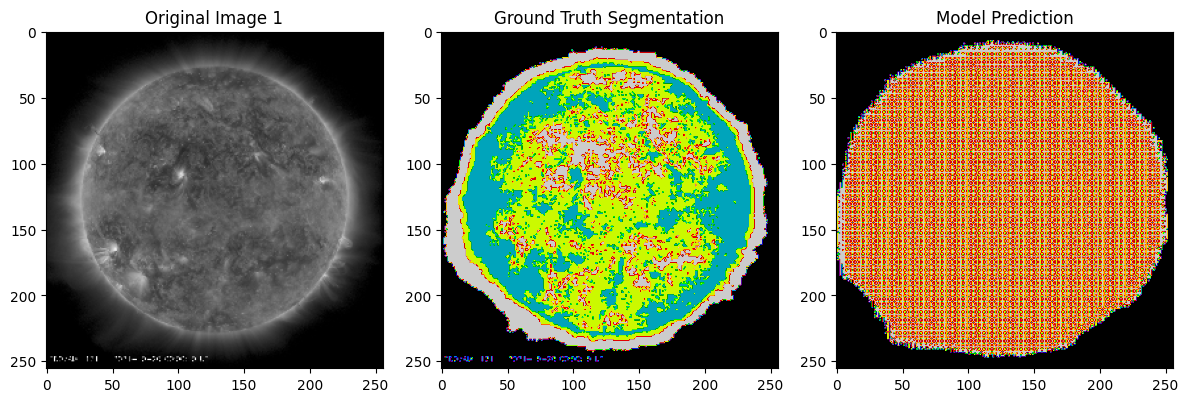


Metrics for Image 1:
Accuracy: 0.480
Precision: 0.556
Recall: 0.480
F1 Score: 0.480
IoU Coronal Holes: 0.786
IoU Solar Flares: 0.054
IoU Active Regions: 0.211
IoU Quiet Regions: 0.208

Composition of features in Image 1:
{np.int64(0): '27.0%', np.int64(1): '4.5%', np.int64(2): '20.1%', np.int64(3): '48.4%'}


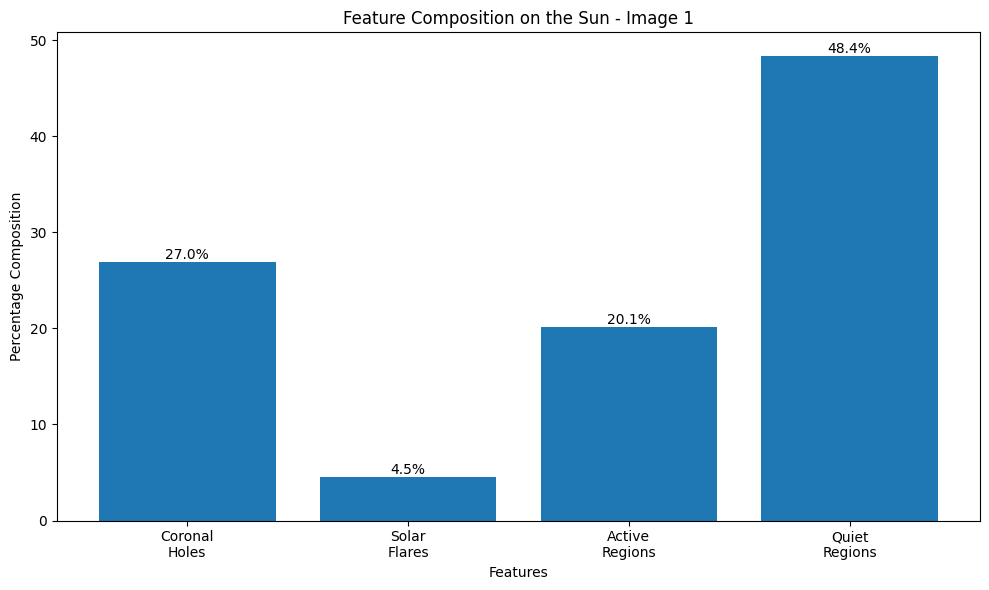

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


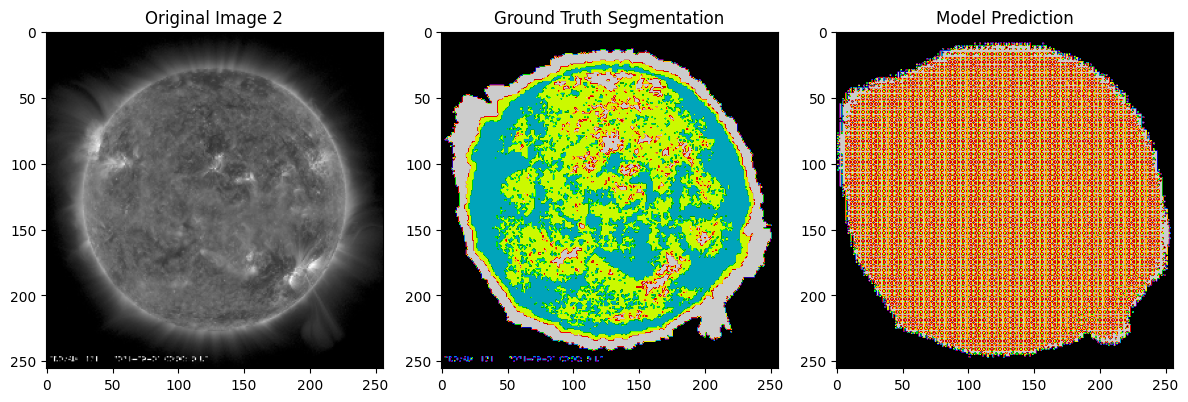


Metrics for Image 2:
Accuracy: 0.460
Precision: 0.561
Recall: 0.460
F1 Score: 0.464
IoU Coronal Holes: 0.776
IoU Solar Flares: 0.055
IoU Active Regions: 0.208
IoU Quiet Regions: 0.178

Composition of features in Image 2:
{np.int64(0): '27.1%', np.int64(1): '4.5%', np.int64(2): '20.1%', np.int64(3): '48.3%'}


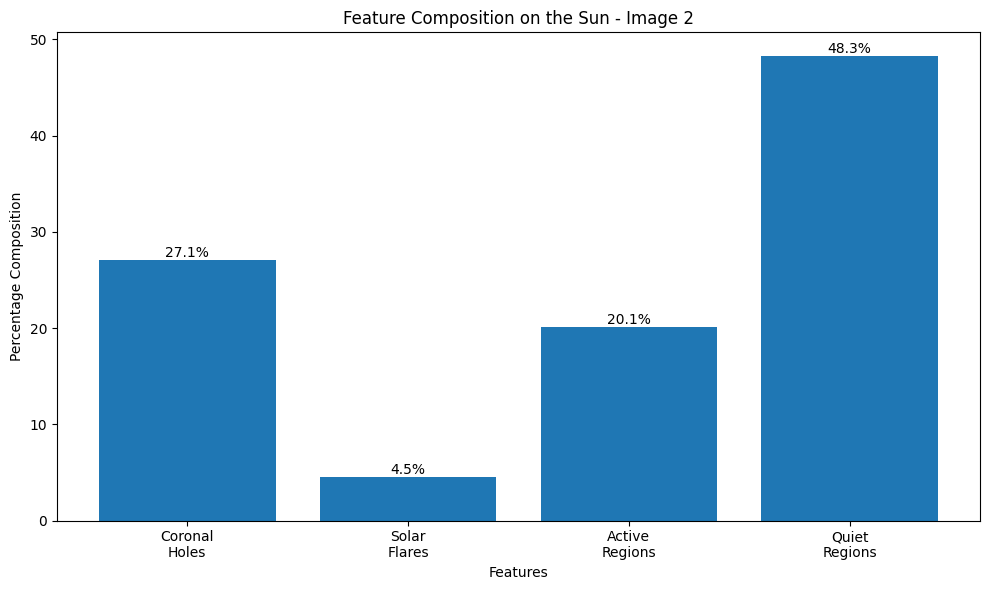

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


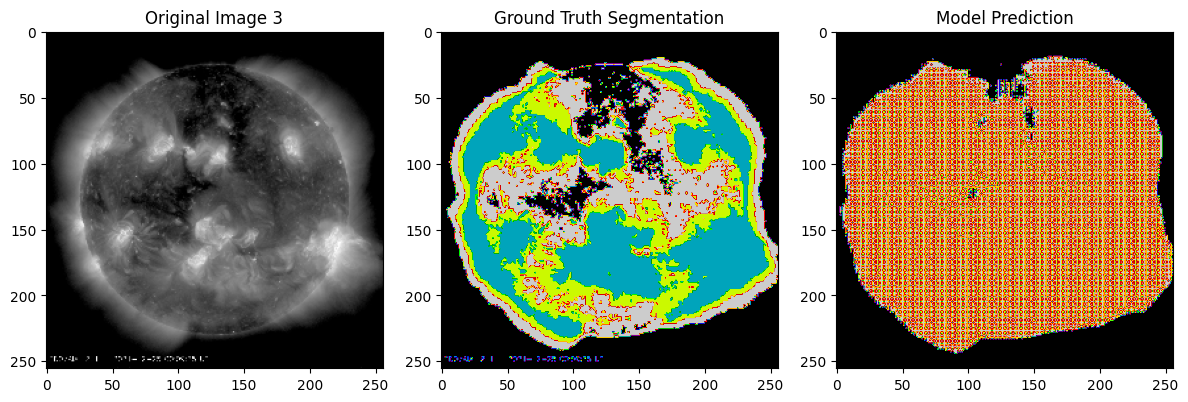


Metrics for Image 3:
Accuracy: 0.523
Precision: 0.567
Recall: 0.523
F1 Score: 0.508
IoU Coronal Holes: 0.822
IoU Solar Flares: 0.054
IoU Active Regions: 0.162
IoU Quiet Regions: 0.274

Composition of features in Image 3:
{np.int64(0): '31.9%', np.int64(1): '4.4%', np.int64(2): '19.1%', np.int64(3): '44.6%'}


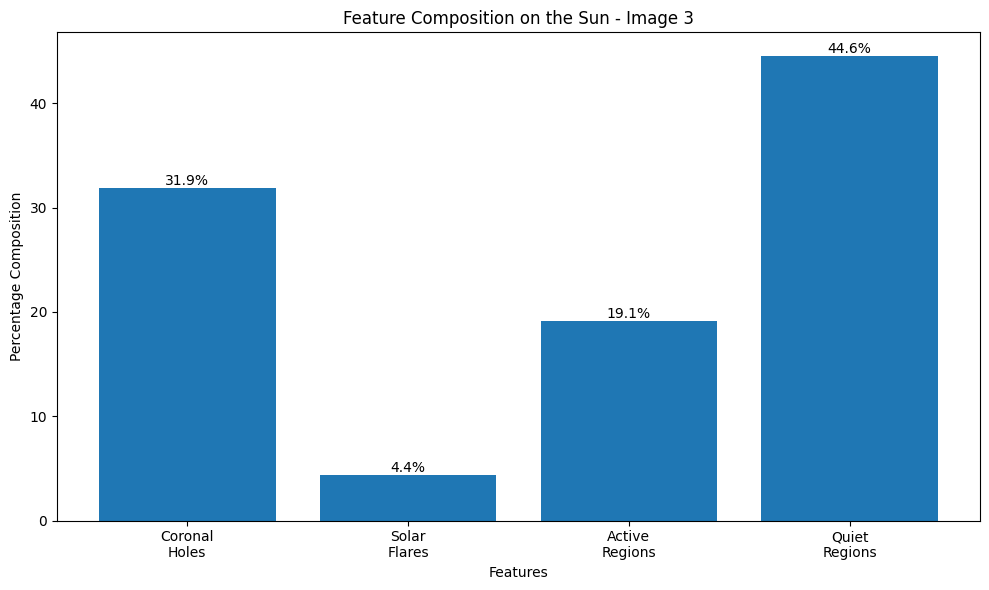


Average Metrics across all test images:
Average Accuracy: 0.488
Average Precision: 0.561
Average Recall: 0.488
Average F1 Score: 0.484
Average IoU Coronal Holes: 0.795
Average IoU Solar Flares: 0.054
Average IoU Active Regions: 0.194
Average IoU Quiet Regions: 0.220


In [31]:
def calculate_feature_composition(segmented_image):
    unique, counts = np.unique(segmented_image, return_counts=True)
    total_pixels = segmented_image.size
    composition = dict(zip(unique, counts / total_pixels * 100))
    return composition

def plot_composition(composition, image_num):
    labels = ['Coronal\nHoles', 'Solar\nFlares', 'Active\nRegions', 'Quiet\nRegions']
    sizes = [composition.get(i, 0) for i in range(4)]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, sizes)
    plt.xlabel('Features')
    plt.ylabel('Percentage Composition')
    plt.title(f'Feature Composition on the Sun - Image {image_num}')
    
    # Add percentage labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Post-processing and plotting for 3 test samples
metrics_summary = []

for i in range(3):  # Select 3 sample test images
    # Run the model prediction
    pred_mask = model.predict(np.expand_dims(val_images[i], axis=0))[0]
    pred_mask_classes = np.argmax(pred_mask, axis=-1)
    true_mask_classes = np.argmax(val_masks[i], axis=-1)
    
    # Calculate metrics
    metrics = calculate_metrics(true_mask_classes, pred_mask_classes)
    metrics_summary.append(metrics)
    
    # Plot original and segmented image
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(val_images[i])
    plt.title(f'Original Image {i+1}')
    
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask_classes, cmap='nipy_spectral')
    plt.title('Ground Truth Segmentation')
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask_classes, cmap='nipy_spectral')
    plt.title('Model Prediction')
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics for this image
    print(f"\nMetrics for Image {i+1}:")
    print(f"Accuracy: {metrics['accuracy']:.3f}")
    print(f"Precision: {metrics['precision']:.3f}")
    print(f"Recall: {metrics['recall']:.3f}")
    print(f"F1 Score: {metrics['f1_score']:.3f}")
    print(f"IoU Coronal Holes: {metrics['iou_coronal_holes']:.3f}")
    print(f"IoU Solar Flares: {metrics['iou_solar_flares']:.3f}")
    print(f"IoU Active Regions: {metrics['iou_active_regions']:.3f}")
    print(f"IoU Quiet Regions: {metrics['iou_quiet_regions']:.3f}")
    
    # Calculate and plot the composition
    composition = calculate_feature_composition(pred_mask_classes)
    print(f"\nComposition of features in Image {i+1}:")
    print({k: f"{v:.1f}%" for k, v in composition.items()})
    plot_composition(composition, i+1)

# Print average metrics across all three images
print("\nAverage Metrics across all test images:")
avg_metrics = {
    metric: np.mean([img_metrics[metric] for img_metrics in metrics_summary])
    for metric in metrics_summary[0].keys()
}
print(f"Average Accuracy: {avg_metrics['accuracy']:.3f}")
print(f"Average Precision: {avg_metrics['precision']:.3f}")
print(f"Average Recall: {avg_metrics['recall']:.3f}")
print(f"Average F1 Score: {avg_metrics['f1_score']:.3f}")
print(f"Average IoU Coronal Holes: {avg_metrics['iou_coronal_holes']:.3f}")
print(f"Average IoU Solar Flares: {avg_metrics['iou_solar_flares']:.3f}")
print(f"Average IoU Active Regions: {avg_metrics['iou_active_regions']:.3f}")
print(f"Average IoU Quiet Regions: {avg_metrics['iou_quiet_regions']:.3f}")